In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import display, clear_output
from tqdm import tqdm
np.set_printoptions(precision=2)
%matplotlib inline

In [2]:
def rgb(o):
    h = hash(o)
    return np.array([ (h := h // 256) % 256 for _ in range(3) ]) / 255

## Optimizers

In [3]:
class Optimizer:
    def __init__(self, weights):
        self.weights = weights

    def __call__(self, grads): ...

In [4]:
class Clip(Optimizer):
    def __init__(self, weights):
        super().__init__(weights)
        self.lr = 1e-2

    def __call__(self, grads):
        for W, dW in zip(self.weights, grads):
            W -= self.lr * np.clip(dW, -1, 1)

In [5]:
class RProp(Optimizer):
    def __init__(self, weights):
        super().__init__(weights)
        self.deltas = [np.random.normal(0, 1, W.shape) for W in self.weights]
        self.sgns = [np.zeros_like(W) for W in self.weights]

    def __call__(self, grads):
        dec = 0.5
        inc = 1.2

        for W, dW, sW, delta in zip(self.weights, grads, self.sgns, self.deltas):
            sdW = np.sign(dW)
            test = sdW * sW
            new_delta = np.clip(delta * (test > 0)*inc + (test < 0)*dec, -1e-2, 1e-2)
            delta *= 0; delta += new_delta
            sW *= 0; sW += sdW
            W -= sW * delta


In [6]:
class Momentum(Optimizer):
    def __init__(self, weights):
        super().__init__(weights)
        self.history = [np.zeros_like(W) for W in self.weights]
        self.g = 0.1

    def __call__(self, grads):
        for W, dW, H in zip(self.weights, grads, self.history):
            update = self.g*H + 1e-2*np.clip(dW, -1, 1)
            H *= 0; H += update
            W -= update

## Model parameters and architecture

In [7]:
def loss(y_pred, y_opt):
    return 0.5 * (y_pred - y_opt)**2

def sample(data):
    n = len(data) - 1
    i, j = sorted([np.random.randint(n), np.random.randint(n)])
    if i == j: i, j = 0, n
    return np.expand_dims(data[i:j], (1, 2)), np.expand_dims(data[j], (0, 1))

class RNN:
    def __init__(self, hidden_dim = 50, optimizer = None):
        # hidden state size
        self.hidden_dim = hidden_dim

        # input weights
        Wx = np.random.normal(0, 1, (hidden_dim, 1))

        # hidden state weights
        Wh = np.random.normal(0, 1, (hidden_dim, hidden_dim))

        # output weights
        Wy = np.random.normal(0, 1, (1, hidden_dim))

        # tanh activation function
        self.T = np.tanh

        self.ws = np.array((Wx, Wh, Wy))
        self.optimizer = Clip(self.ws)
        if optimizer:
            self.optimizer = optimizer(self.ws)
    
    def cell(self, xt, ht):
        Wx, Wh, Wy = self.ws
        ht = self.T(Wx @ xt + Wh @ ht)
        yt = Wy @ ht
        return ht, yt

    def forward(self, xs):
        ht = np.zeros((self.hidden_dim, 1))
        hs = [ht]
        
        for t in range(len(xs)):
            xt = xs[t]
            ht, yt = self.cell(xt, ht)
            hs.append(ht)
        return yt, hs

    def backward(self, xs, hs, y, y_true):
        Wx, Wh, Wy = self.ws
        dy = y - y_true
        dWy = dy @ hs[-1].T
        dht = Wy.T @ dy
        dWx = np.zeros_like(Wx)
        dWh = np.zeros_like(Wh)

        for t in reversed(range(len(xs))):
            dT = dht * (1 - hs[t+1]**2)
            dWx += dT @ xs[t]
            dWh += dT @ hs[t].T
            dht = Wh.T @ dT
        
        self.optimizer(np.array((dWx, dWh, dWy)))

    def predict(self, xs):
        return self.forward(np.expand_dims(xs, axis=(1, 2)))[0].squeeze()

    def test(self, data, start = 0, length = 50):
        y_true, y_pred = [], []
        for i in range(1, len(data)):
            y_true.append(data[i])
            y_pred.append(self.predict(data[start : i]))

        plt.plot(y_true, linestyle='--')
        plt.plot(
            y_pred,
            color=rgb(str(type(self.optimizer))),
            linewidth=1,
            antialiased=True
        )
    
    def train(self, data, verbose=True, n = None):
        hist = deque(maxlen=1000)
        try:
            n = n or 10000
            for step in tqdm(range(n)):
                xs, y_true = sample(data)
                y, hs = self.forward(xs)
                self.backward(xs, hs, y, y_true)
                hist.append(loss(y, y_true).squeeze())

                if verbose and not step % (n//20):
                    clear_output(wait=True)
                    print(np.mean(hist))
                    fig = plt.figure(figsize=(10, 8))
                    plt.subplot(211)
                    plt.plot(hist)
                    plt.subplot(212)
                    self.test(data)
                    plt.show()

        except KeyboardInterrupt:
            ...

## Data generation

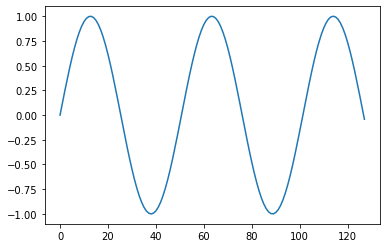

In [8]:
# X ~ (samples, values, 1, 1)
# Y ~ (samples, 1, 1)
dataset_size = 128
sine = np.sin(np.linspace(0, 15.75, dataset_size))
p = plt.plot(sine)

## Train and test the model

0.13942605472405528


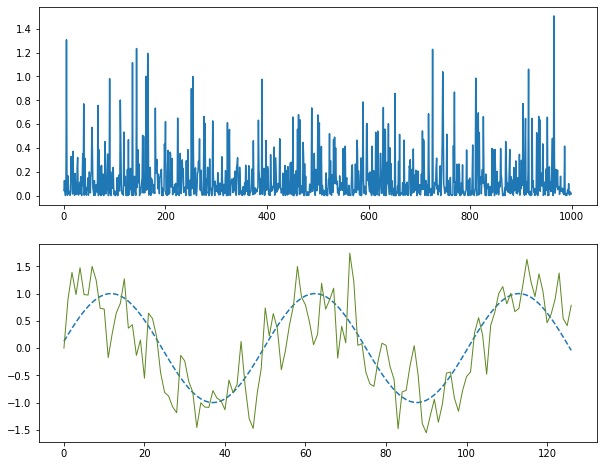

100%|██████████| 100000/100000 [03:49<00:00, 436.32it/s]


In [9]:
RNN(optimizer = RProp).train(sine, n = 100000)

0.002268734036333547


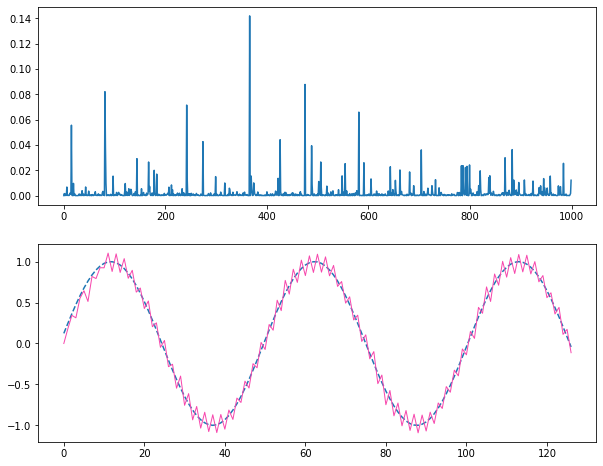

100%|██████████| 100000/100000 [03:11<00:00, 521.37it/s]


In [10]:
RNN(optimizer = Clip).train(sine, n = 100000)

0.016624706514891063


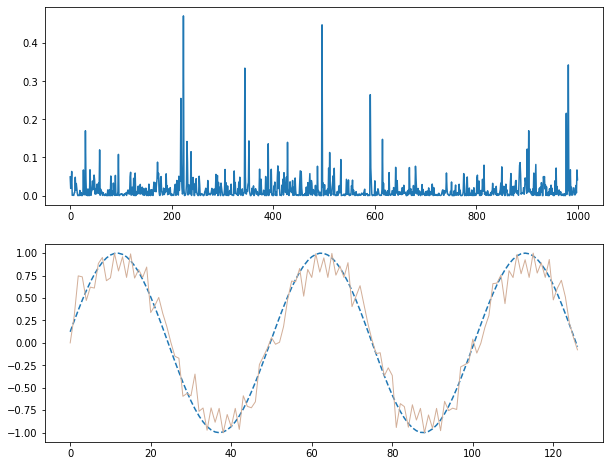

100%|██████████| 100000/100000 [03:12<00:00, 518.97it/s]


In [11]:
RNN(optimizer = Momentum).train(sine, n = 100000)

1.207399803276486


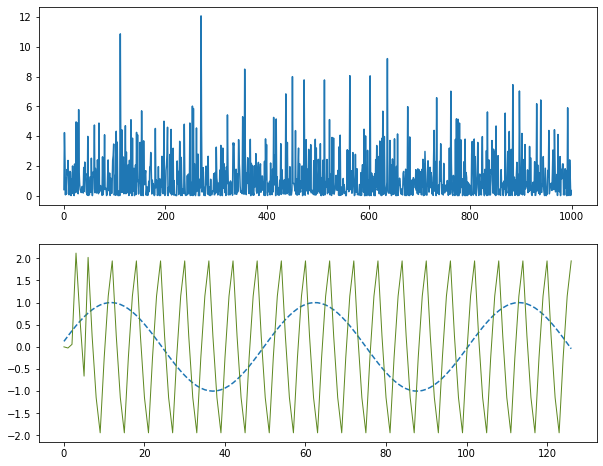

100%|██████████| 100000/100000 [35:54<00:00, 46.41it/s]


In [12]:
RNN(hidden_dim = 200, optimizer = RProp).train(sine, n = 100000)

0.22722433794943991


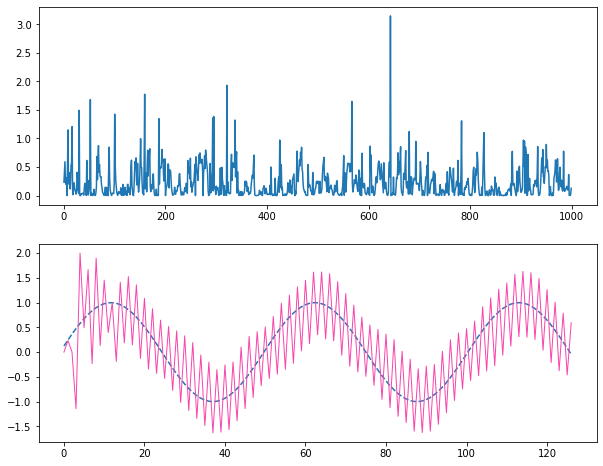

100%|██████████| 100000/100000 [33:44<00:00, 49.40it/s]


In [13]:
RNN(hidden_dim = 200, optimizer = Clip).train(sine, n = 100000)

0.34778648956310726


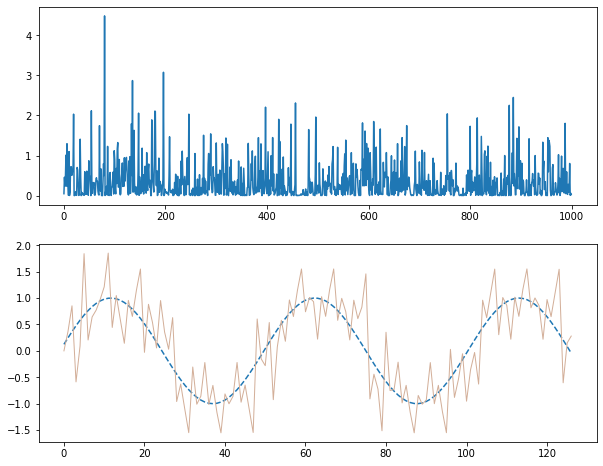

100%|██████████| 100000/100000 [34:21<00:00, 48.52it/s]


In [15]:
RNN(hidden_dim = 200, optimizer = Momentum).train(sine, n = 100000)